**[Intermediate Machine Learning Micro-Course Home Page](https://www.kaggle.com/learn/intermediate-machine-learning)**

---


In this exercise, you will use **pipelines** to improve the efficiency of your machine learning code.

# Setup

The questions below will give you feedback on your work. Run the following cell to set up the feedback system.

In [1]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex4 import *
print("Setup Complete")

Setup Complete


You will work with data from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course). 

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)

Run the next code cell without changes to load the training and validation sets in `X_train`, `X_valid`, `y_train`, and `y_valid`.  The test set is loaded in `X_test`.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [3]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,...,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,...,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,843,468,81,0,0,0,0,0,1,2006


The next code cell uses code from the tutorial to preprocess the data and train a model.  Run this code without changes.

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17861.780102739725


The code yields a value around 17862 for the mean absolute error (MAE).  In the next step, you will amend the code to do better.

# Step 1: Improve the performance

### Part A

Now, it's your turn!  In the code cell below, define your own preprocessing steps and random forest model.  Fill in values for the following variables:
- `numerical_transformer`
- `categorical_transformer`
- `model`

To pass this part of the exercise, you need only define valid preprocessing steps and a random forest model.

In [28]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=250, random_state=0)

# Check your answer
step_1.a.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Optimal number of n_estimators:  250                                                                                                  


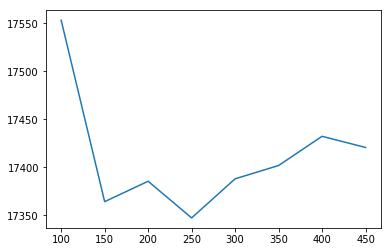

In [27]:
import matplotlib.pyplot as plt

def get_mae(n_estimators, X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
    my_pipeline.fit(X_train, y_train)
    preds = my_pipeline.predict(X_valid)
    score = mean_absolute_error(y_valid, preds)
    return(score)

d = {}

for candidate in range(100, 500, 50):
    mae = get_mae(candidate, X_train, X_valid, y_train, y_valid)
    print("Checking MAE for " + str(candidate) + 
          ", please wait." +
          " "*100, end="\r")
    d.update( {candidate : mae} )

# Show all MAEs on a plot
lists = sorted(d.items())
x, y = zip(*lists)
plt.plot(x, y)

# Store the best value in a variable
best_n_estimators = min(d, key=d.get)
print("Optimal number of n_estimators: ", best_n_estimators)

In [ ]:
# Lines below will give you a hint or solution code
#step_1.a.hint()
#step_1.a.solution()

### Part B

Run the code cell below without changes.

To pass this step, you need to have defined a pipeline in **Part A** that achieves lower MAE than the code above.  You're encouraged to take your time here and try out many different approaches, to see how low you can get the MAE!  (_If your code does not pass, please amend the preprocessing steps and model in Part A._)

In [29]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

# Check your answer
step_1.b.check()

MAE: 17347.323369863017


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Line below will give you a hint
#step_1.b.hint()

# Step 2: Generate test predictions

Now, you'll use your trained model to generate predictions with the test data.

In [30]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)

# Check your answer
step_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#step_2.hint()
#step_2.solution()

Run the next code cell without changes to save your results to a CSV file that can be submitted directly to the competition.

In [31]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

# Step 3: Submit your results

Once you have successfully completed Step 2, you're ready to submit your results to the leaderboard!  (_You also learned how to do this in the previous exercise.  If you need a reminder of how to do this, please use the instructions below._)
- Begin by clicking on the blue **COMMIT** button in the top right corner.  This will generate a pop-up window.  
- After your code has finished running, click on the blue **Open Version** button in the top right of the pop-up window.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
- Click on the **Output** tab on the left of the screen.  Then, click on the **Submit to Competition** button to submit your results to the leaderboard.
- If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your model and repeat the process.

# Keep going

Move on to learn about [**cross-validation**](https://www.kaggle.com/alexisbcook/cross-validation), a technique you can use to obtain more accurate estimates of model performance!

---
**[Intermediate Machine Learning Micro-Course Home Page](https://www.kaggle.com/learn/intermediate-machine-learning)**

